In [2]:
import warp as wp
wp.init()
import numpy as np

Warp 0.6.1 initialized:
   CUDA Toolkit: 11.5, Driver: 11.7
   Devices:
     "cpu"    | Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
     "cuda:0" | Quadro P1000 (sm_61)
   Kernel cache: C:\Users\20192037\AppData\Local\NVIDIA Corporation\warp\Cache\0.6.1


### Test code

In [3]:
train_img = np.array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          3,  18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  30,  36,
         94, 154, 170, 253, 253, 253, 253, 253, 225, 172, 253, 242, 195,
         64,   0,   0,   0,   0,   0,   0,   0,   0], dtype=np.int16)
test_img = np.array([ 93,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0, 169, 253, 253, 253, 253,
        253, 253, 218,  30,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0, 169, 253, 253, 253,
        213, 142, 176, 253, 253, 122,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  52, 250, 253,
        210,  32,  12,   0,   6, 206, 253, 140,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=np.int16)

In [4]:
@wp.kernel
def sq_add(train_img: wp.array(dtype=float),
           test_img: wp.array(dtype=float),
           sq_sum: wp.array(dtype=float)):

   # thread index
   tid = wp.tid()
    
   sq_abs = wp.pow(train_img[tid] - test_img[tid], 2.0)
   
   wp.atomic_add(sq_sum, 0, sq_abs)

In [5]:
print(sum(i**2 for i in train_img-test_img))

wptrain = wp.from_numpy(train_img, dtype=float)
wptest = wp.from_numpy(test_img, dtype=float)
wpresults = wp.array([0], dtype=float)

wp.launch(kernel=sq_add,
          dim=len(train_img),
          inputs=[wptrain, wptest, wpresults])

print(wpresults.numpy())

1583682
Module __main__ load on device 'cuda:0' took 992.48 ms
[1583682.]


In [6]:
@wp.kernel
def img_norm(train_imgs: wp.array(dtype=float, ndim=2),
           test_img: wp.array(dtype=float),
           n: int,
           p: float,
           norms: wp.array(dtype=float)):

    # thread index
    tid = wp.tid()

    train_img = train_imgs[tid]

    s = float(0)
    for i in range(n):
        diff = wp.abs(train_img[i] - test_img[i])
        s += wp.pow(diff, p)
    
    norms[tid] = wp.pow(s, 1.0/p)

In [7]:
print(np.linalg.norm(train_img-test_img))

train_imgs = np.tile(train_img, (10,1))
wptrain = wp.from_numpy(train_imgs, dtype=float)
wptest = wp.from_numpy(test_img, dtype=float)
wpresults = wp.empty(shape=len(train_imgs), dtype=float)

wp.launch(kernel=img_norm,
          dim=len(train_imgs),
          inputs=[wptrain, wptest, len(test_img), 2, wpresults])

print(wpresults.numpy())

1258.4442776698538
Module __main__ load on device 'cuda:0' took 1159.56 ms
[1258.4442 1258.4442 1258.4442 1258.4442 1258.4442 1258.4442 1258.4442
 1258.4442 1258.4442 1258.4442]


### Run code

In [8]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from collections import Counter
from time import perf_counter

Image functions

In [9]:
def get_images(name, size):
    images = np.empty((size, 784), dtype=np.int16)
    numbers = np.empty(size, dtype=np.int32)

    with open(name, 'rt') as file:
        for i in range(size):
            row = file.readline().split(',')

            numbers[i] = row[0]
            images[i] = row[1:]

    return numbers, images

def show_image(image):
    plt.imshow(image.reshape((28,28)), cmap='gray')
    plt.show()

Latex functions

In [10]:
def create_latex_table(lists, caption = None, label = None):
    
    n = len(list(lists[0]))
    start = "\\begin{table}[H] \n\\centering \n\\begin{tabular}{|" + "l|" * n + "} \\hline \n"

    add_middle = lambda x: " & ".join(list(map(str, x))) + " \\\\ \hline"

    middle = "\n".join(list(map(add_middle, lists)))

    ref = ("\n\\caption{" + caption + "}" if caption else "") + "\n\\label{" + label + "}" if label else ""

    end = "\n\\end{tabular}" + ref + "\n\\end{table}"

    print(start + middle + end)

    return None

def create_matrix(mat, xlab = "i", ylab = "j", mat_name = "S", dx = 0, dy = 0):

    nx = len(list(mat[0]))
    ny = len(list(mat))
    start = "\\begin{table}[H] \n\\centering \n\\begin{tabular}{l|" + "c" * nx + "} \\hline \n"

    header = f"\\backslashbox{{{ylab}}}{{{xlab}}} & " + " & ".join(list(map(str,range(1 + dx, dx + nx + 1)))) + " \\\\ \hline \n"

    add_middle = lambda i: str(i+1+dy) + " & " + " & ".join(list(map(str, mat[i]))) + " \\\\"

    middle = "\n".join(list(map(add_middle, range(ny))))

    end = "\n\\end{tabular}" + "\n\\end{table}"

    print(start + header + middle + end)

    return None

Cpu functions

In [11]:
def mink_dist(x, y, p=2):
    return np.linalg.norm(x - y, ord=p, axis=-1)

not_eq = lambda x,y: x != y

def k_nearest_neighbours(train_images, train_numbers, test_image, k, dist_func):
    norm_list = dist_func(train_images, test_image)
    nearest_idx = np.empty(k, dtype=np.int32)
    common_nr = np.empty(k, dtype=np.int8)
    for i in range(k):
        min_idx = np.argmin(norm_list)
        norm_list[min_idx] = np.inf
        nearest_idx[i] = min_idx

        common_nr[i] = Counter(train_numbers[nearest_idx[:i+1]]).most_common(1)[0][0]

    return common_nr

def k_nearest_neighbours_LOOCV(train_images, train_numbers, test_image, k, dist_func, index):
    """ 
    Applies the k-NN approach, while disregarding index from the train images (LOOCV)
    """
    assert 0 <= index and index < train_images.size, "Index out of range"
    
    return k_nearest_neighbours(np.delete(train_images, index, axis = 0), np.delete(train_numbers, index), test_image, k, dist_func)

def cross_validation(train_images, train_numbers, k_range, dist_func):
    """
    Computes the cross-validation score of the training dataset for each k in the range 1 to k_range
    """

    # Prediction rule for image at index while leaving index out of training
    neighbour_LOOCV_func = lambda index: k_nearest_neighbours_LOOCV(train_images, train_numbers, train_images[index], k_range, dist_func, index)

    train_common_nrs_LOOCV = np.array(list(map(neighbour_LOOCV_func, range(train_numbers.size)))).transpose()

    LOOCV_scores = np.sum(not_eq(train_common_nrs_LOOCV, train_numbers), axis=1)/train_numbers.size

    return LOOCV_scores

Gpu functions

In [12]:
def k_nearest_neighbours_gpu(wpimages_train, train_numbers, img, k, p, leave_out = 0):
    wpimages_train_len = wpimages_train.shape[0]
    wpimg = wp.from_numpy(img, dtype=float, device='cuda:0')
    wpresults = wp.empty(shape=wpimages_train_len, dtype=float, device='cuda:0')

    wp.launch(kernel=img_norm,
          dim=wpimages_train_len,
          inputs=[wpimages_train, wpimg, wpimg.size, p, wpresults],
          device='cuda:0')

    norm_list = wpresults.numpy()

    nearest_idx = np.empty(k, dtype=np.int32)
    common_nr = np.empty(k, dtype=np.int8)
    for i in range(leave_out):
        min_idx = np.argmin(norm_list)
        norm_list[min_idx] = np.inf
    for i in range(k):
        min_idx = np.argmin(norm_list)
        norm_list[min_idx] = np.inf
        nearest_idx[i] = min_idx

        common_nr[i] = Counter(train_numbers[nearest_idx[:i+1]]).most_common(1)[0][0]

    return common_nr

def k_nearest_neighbours_gpu_LOOCV(wpimages_train, train_numbers, img, k, p):
    """ 
    Applies the k-NN approach, while disregarding index from the train images (LOOCV)
    by discarding the closest neighbor, i.e. itself
    """
    return k_nearest_neighbours_gpu(wpimages_train, train_numbers, img, k, p, leave_out=1)

def cross_validation_gpu(train_images, train_numbers, k, p):
    """
    Computes the cross-validation score of the training dataset for each k in the range 1 to k_range
    """
    wpimages_train = wp.from_numpy(train_images, dtype=float, device='cuda:0')
    # Prediction rule for image at index while leaving index out of training
    neighbour_LOOCV_func = lambda index: k_nearest_neighbours_gpu_LOOCV(wpimages_train, train_numbers, train_images[index], k, p)

    train_common_nrs_LOOCV = np.array(list(map(neighbour_LOOCV_func, range(train_numbers.size)))).transpose()

    LOOCV_scores = np.sum(not_eq(train_common_nrs_LOOCV, train_numbers), axis=1)/train_numbers.size

    return LOOCV_scores

In [13]:
numbers_train, images_train = get_images('data/MNIST_train.csv', 60000)
numbers_test, images_test = get_images('data/MNIST_test.csv', 10000)

In [14]:
numbers_train_small, images_train_small = get_images('data/MNIST_train_small.csv', 3000)
numbers_test_small, images_test_small = get_images('data/MNIST_test_small.csv', 1000)

Speed comparison

In [ ]:
%%timeit
k = 20
img = images_test[0]
time_list = np.empty(10)

# Time dist
dist_time = perf_counter()
norm_list = euclid_dist(images_train, img)
dist_time = perf_counter() - dist_time
print(f"Dist time: {dist_time}")

nearest_idx = np.empty(k, dtype=np.int32)
common_nr = np.empty(k, dtype=np.int8)

# Time get nearest
nearest_time = perf_counter()
for i in range(k):
    min_idx = np.argmin(norm_list)
    norm_list[min_idx] = np.inf
    nearest_idx[i] = min_idx

    common_nr[i] = Counter(numbers_train[nearest_idx[:i+1]]).most_common(1)[0][0]
nearest_time = perf_counter() - nearest_time
print(f"Neasest k time: {nearest_time}")

### Exercises

Ex. A

In [122]:
k = 20
p = 2

wpimages_train_small = wp.from_numpy(images_train_small, dtype=float, device='cuda:0')

def neighbour_func(img):
    return k_nearest_neighbours_gpu(wpimages_train_small, numbers_train_small, img, k, p)

In [123]:
test_common_nrs = np.array(list(map(neighbour_func, images_test_small))).transpose()
train_common_nrs = np.array(list(map(neighbour_func, images_train_small))).transpose()

In [124]:
test_small_risk = np.sum(not_eq(test_common_nrs, numbers_test_small), axis=1)/numbers_test_small.shape[0]
train_small_risk = np.sum(not_eq(train_common_nrs, numbers_train_small), axis=1)/numbers_train_small.shape[0]

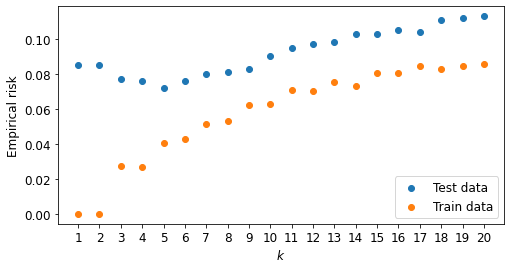

In [125]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(range(1,k+1), test_small_risk, label='Test data')
ax.scatter(range(1,k+1), train_small_risk, label='Train data')
ax.legend(loc=4)
ax.set_xlabel(r"$k$")
ax.set_ylabel("Empirical risk")
ax.xaxis.set_ticks(list(range(1,21)))

plt.savefig("Figures/ex_a_risk.pdf")
plt.show()

# Best k for this model is five!

Ex. B

In [18]:
k = 20
p = 2
LOOCV_scores = cross_validation_gpu(images_train_small, numbers_train_small, k, p)

In [19]:
round_to_three = lambda x: "{:0.3f}".format(x)
LOOCV_scores_rounded = list(map(round_to_three, LOOCV_scores))
k_min = ", ".join(list(map(str, 1 + np.where(abs(LOOCV_scores - np.min(LOOCV_scores)) < 1e-10)[0])))
caption = f"Leave-One-Out Cross-Validation (LOOCV) score over the training dataset (minimized for k = {k_min})"
label = "tab:LOOCV_small"
create_latex_table([["$k$", *range(1, 11)], ["LOOCV", *LOOCV_scores_rounded[:10]], ["$k$", *range(11, 21)], ["LOOCV", *LOOCV_scores_rounded[10:20]]], caption = caption, label = label)

\begin{table}[H] 
\centering 
\begin{tabular}{|l|l|l|l|l|l|l|l|l|l|l|} \hline 
$k$ & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 \\ \hline
LOOCV & 0.081 & 0.081 & 0.073 & 0.073 & 0.078 & 0.079 & 0.082 & 0.082 & 0.083 & 0.089 \\ \hline
$k$ & 11 & 12 & 13 & 14 & 15 & 16 & 17 & 18 & 19 & 20 \\ \hline
LOOCV & 0.088 & 0.089 & 0.092 & 0.093 & 0.094 & 0.095 & 0.096 & 0.096 & 0.098 & 0.098 \\ \hline
\end{tabular}
\caption{Leave-One-Out Cross-Validation (LOOCV) score over the training dataset (minimized for k = 3, 4)}
\label{tab:LOOCV_small}
\end{table}


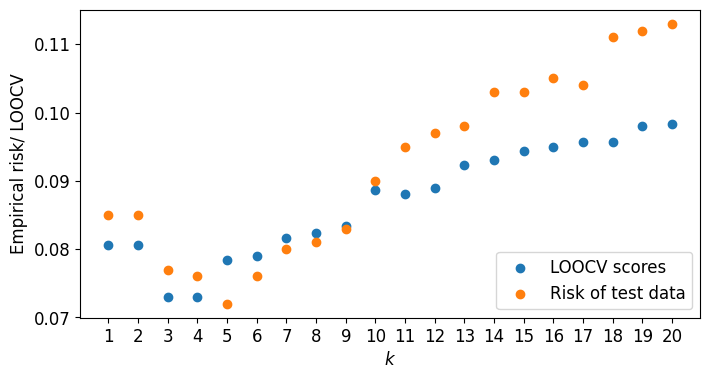

In [20]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(range(1,k+1), LOOCV_scores, label='LOOCV scores')
ax.scatter(range(1,k+1), test_small_risk, label='Risk of test data')
ax.legend(loc=4)
ax.set_xlabel(r"$k$")
ax.set_ylabel("Empirical risk/ LOOCV")
ax.xaxis.set_ticks(list(range(1,21)))

plt.savefig("Figures/ex_b_risk_LOOCV.pdf")
plt.show()

Ex. C

In [137]:
k_range = 20
p_range = 15
LOOCV_scores_minkowski_p = lambda p: cross_validation_gpu(images_train_small, numbers_train_small, k_range, p)

LOOCV_scores_minkowski = np.array(list(map(LOOCV_scores_minkowski_p, range(1, p_range + 1))))

In [22]:
round_to_three = lambda x: "{:0.3f}".format(x)
round_to_three_list = lambda x: list(map(round_to_three, x))
LOOCV_scores_minkowski_rounded = list(map(round_to_three_list, LOOCV_scores_minkowski))
create_matrix([x[:10] for x in LOOCV_scores_minkowski_rounded], xlab = "$k$", ylab = "$p$")

\begin{table}[H] 
\centering 
\begin{tabular}{l|cccccccccc} \hline 
\backslashbox{$p$}{$k$} & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 \\ \hline 
1 & 0.090 & 0.090 & 0.090 & 0.083 & 0.091 & 0.090 & 0.097 & 0.091 & 0.097 & 0.097 \\
2 & 0.081 & 0.081 & 0.073 & 0.073 & 0.078 & 0.079 & 0.082 & 0.082 & 0.083 & 0.089 \\
3 & 0.075 & 0.075 & 0.066 & 0.069 & 0.073 & 0.077 & 0.078 & 0.078 & 0.080 & 0.084 \\
4 & 0.073 & 0.073 & 0.065 & 0.067 & 0.069 & 0.074 & 0.077 & 0.075 & 0.076 & 0.077 \\
5 & 0.073 & 0.073 & 0.061 & 0.068 & 0.069 & 0.069 & 0.074 & 0.074 & 0.077 & 0.075 \\
6 & 0.071 & 0.071 & 0.061 & 0.066 & 0.068 & 0.066 & 0.072 & 0.071 & 0.076 & 0.072 \\
7 & 0.071 & 0.071 & 0.058 & 0.064 & 0.066 & 0.066 & 0.071 & 0.070 & 0.074 & 0.072 \\
8 & 0.069 & 0.069 & 0.058 & 0.063 & 0.064 & 0.063 & 0.070 & 0.069 & 0.071 & 0.069 \\
9 & 0.069 & 0.069 & 0.058 & 0.062 & 0.064 & 0.064 & 0.071 & 0.068 & 0.069 & 0.069 \\
10 & 0.070 & 0.070 & 0.059 & 0.062 & 0.066 & 0.064 & 0.070 & 0.068 & 0.069 & 0.071 \\
11 & 

In [23]:
create_matrix([x[10:] for x in LOOCV_scores_minkowski_rounded], xlab = "$k$", ylab = "$p$", dx = 10)

\begin{table}[H] 
\centering 
\begin{tabular}{l|cccccccccc} \hline 
\backslashbox{$p$}{$k$} & 11 & 12 & 13 & 14 & 15 & 16 & 17 & 18 & 19 & 20 \\ \hline 
1 & 0.099 & 0.101 & 0.103 & 0.102 & 0.108 & 0.107 & 0.110 & 0.110 & 0.111 & 0.113 \\
2 & 0.088 & 0.089 & 0.092 & 0.093 & 0.094 & 0.095 & 0.096 & 0.096 & 0.098 & 0.098 \\
3 & 0.085 & 0.085 & 0.086 & 0.085 & 0.091 & 0.090 & 0.093 & 0.091 & 0.096 & 0.095 \\
4 & 0.078 & 0.082 & 0.083 & 0.081 & 0.088 & 0.086 & 0.088 & 0.088 & 0.092 & 0.092 \\
5 & 0.076 & 0.076 & 0.080 & 0.079 & 0.082 & 0.082 & 0.088 & 0.087 & 0.088 & 0.091 \\
6 & 0.073 & 0.073 & 0.077 & 0.077 & 0.083 & 0.081 & 0.083 & 0.085 & 0.085 & 0.087 \\
7 & 0.074 & 0.072 & 0.076 & 0.078 & 0.081 & 0.081 & 0.083 & 0.082 & 0.084 & 0.087 \\
8 & 0.071 & 0.071 & 0.074 & 0.076 & 0.079 & 0.081 & 0.082 & 0.082 & 0.086 & 0.087 \\
9 & 0.074 & 0.071 & 0.074 & 0.076 & 0.077 & 0.080 & 0.081 & 0.082 & 0.086 & 0.086 \\
10 & 0.075 & 0.072 & 0.074 & 0.076 & 0.078 & 0.080 & 0.078 & 0.082 & 0.084 & 0.085

In [138]:
# Index of minimum p and k
min_index = np.unravel_index(LOOCV_scores_minkowski.argmin(), LOOCV_scores_minkowski.shape)
print(min_index, LOOCV_scores_minkowski[min_index])
# p = 8, k = 3, estimated risk = 0.0577

(7, 2) 0.057666666666666665


Ex. E

In [25]:
k = 20
p = 8

In [26]:
# 10 minutes on a NVIDIA RTX 3070
# LOOCV_scores_large = cross_validation_gpu(images_train, numbers_train, k, p)

In [169]:
LOOCV_scores_large = np.array([0.02158333, 0.02158333, 0.02113333, 0.02036667, 0.0219    ,
       0.0214    , 0.0228    , 0.02233333, 0.02406667, 0.02381667,
       0.02553333, 0.02546667, 0.02665   , 0.02655   , 0.02786667,
       0.02783333, 0.02855   , 0.02881667, 0.02955   , 0.02941667])

print(LOOCV_scores_large[3])

0.02036667


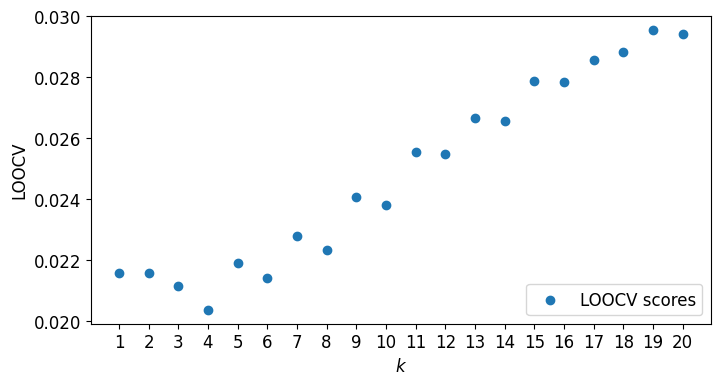

In [31]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(range(1,k+1), LOOCV_scores_large, label='LOOCV scores')
ax.legend(loc=4)
ax.set_xlabel(r"$k$")
ax.set_ylabel("LOOCV")
ax.xaxis.set_ticks(list(range(1,21)))

plt.savefig("Figures/ex_e_risk_LOOCV.pdf")
plt.show()

Ex. F

In [173]:
p = 8
k = 20

wpimages_train_large = wp.from_numpy(images_train, dtype=float, device='cuda:0')
neighbour_func_large = lambda img: k_nearest_neighbours_gpu(wpimages_train_large, numbers_train, img, k, p)

In [174]:
test_common_nrs_large = np.array(list(map(neighbour_func_large, images_test))).transpose()

In [175]:
# test_risk_large = np.sum(not_eq(test_common_nrs_large, numbers_test), axis=1)/numbers_test.shape[0]
test_risk_large = np.array([0.0273, 0.0273, 0.0251, 0.0236, 0.0238, 0.0237, 0.0247, 0.0237,
       0.0252, 0.0255, 0.0276, 0.027 , 0.0285, 0.0275, 0.0295, 0.0297,
       0.0305, 0.03  , 0.0314, 0.0309])

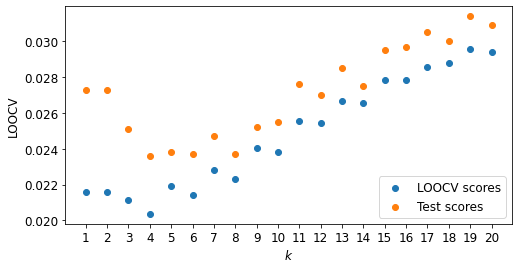

In [177]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(range(1,k+1), LOOCV_scores_large, label='LOOCV scores')
ax.scatter(range(1,k+1), test_risk_large, label='Test scores')
ax.legend(loc=4)
ax.set_xlabel(r"$k$")
ax.set_ylabel("LOOCV")
ax.xaxis.set_ticks(list(range(1,21)))

plt.savefig("Figures/ex_f_risk_LOOCV.pdf")
plt.show()

Ex. G

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [37]:
scaler = StandardScaler()
scaled_images_train_small = scaler.fit_transform(images_train_small)

In [76]:
pca_test = PCA(n_components=100)
pca_test_fit = pca_test.fit(scaled_images_train_small)

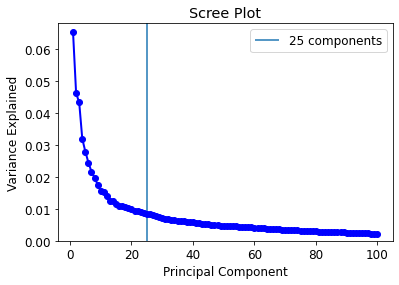

In [107]:
PC_values = np.arange(pca_test.n_components_) + 1
plt.plot(PC_values, pca_test.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.vlines(25, -1, 1, label="25 components")
plt.ylim([0, 0.068])
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend()
plt.show()

In [99]:
sum(pca_test.explained_variance_ratio_[:25])

0.47656369473536486

In [160]:
# transform large data set and find performance
pca = PCA(n_components=25)
pca.fit(scaled_images_train_small)

reduced_images_train_small = pca.transform(images_train_small)
reduced_images_test_small = pca.transform(images_test_small)

reduced_images_train = pca.transform(images_train)
reduced_images_test = pca.transform(images_test)

In [139]:
k_range = 20
p_range = 15
reduces_LOOCV_scores_minkowski_p = lambda p: cross_validation_gpu(reduced_images_train_small, numbers_train_small, k_range, p)

reduces_LOOCV_scores_minkowski = np.array(list(map(reduces_LOOCV_scores_minkowski_p, range(1, p_range + 1))))

In [140]:
# Index of minimum p and k
reduces_min_index = np.unravel_index(reduces_LOOCV_scores_minkowski.argmin(), reduces_LOOCV_scores_minkowski.shape)
print(reduces_min_index, reduces_LOOCV_scores_minkowski[reduces_min_index])
# p = 2, k = 3, estimated risk = 0.075

(1, 2) 0.075


In [141]:
p = 2
k = 3
# reduces_LOOCV_scores_reduces_large = cross_validation_gpu(reduced_images_train, numbers_train, k, p)
reduces_LOOCV_scores_reduces_large = np.array([0.03735   , 0.03735   , 0.03401667])

In [144]:
# Estimated risk of reduced training set
reduces_LOOCV_scores_reduces_large[2]
# 0.03401666666666667

array([0.03735   , 0.03735   , 0.03401667])

In [161]:
p = 2
k = 3

wpreduces_images_train = wp.from_numpy(reduced_images_train, dtype=float, device='cuda:0')
reduced_neighbour_func = lambda img: k_nearest_neighbours_gpu(wpreduces_images_train, numbers_train, img, k, p)

In [162]:
# reduces_test_common_nrs = np.array(list(map(reduced_neighbour_func, reduced_images_test))).transpose()

In [163]:
# reduces_test_risk = np.sum(not_eq(reduces_test_common_nrs, numbers_test), axis=1)/numbers_test.shape[0]
reduces_test_risk = np.array([0.0455, 0.0455, 0.0392])

In [167]:
# risk of reduced training set
reduces_test_risk[2]
# 0.0392

array([0.0455, 0.0455, 0.0392])